# Descomposicion de una serie temporal

In [1]:
import numpy as np
from api_somo import fetch_qf
from utils.utils import reshample_time_serie, categorize_precipitation
from graphics_utils.express import fig_boxplot
from statistics_utils.eda.timeseries import decompose_time_series, test_stationarity
from graphics_utils.go import multi_scatter

In [6]:
from api_somo import DataFetcher
import logging

# Setting up logging for the main script
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

api_url = "http://127.0.0.1:8000/database/filter-serie/"
params = {
    "station_name": "tumaco",
    "variable_name": "Precipitación acumulada",
    "processing_level_name": "Control de calidad",
    "start_date":"2010-01-01",
    "end_date":"2010-12-31"
    }

try:
    # 1. Fetch and process the data
    historical_series = DataFetcher.fetch_and_process_data(api_url, params)

    if historical_series.empty:
        raise ValueError("The historical series is empty.")

    # Additional processing with the historical series
    logger.info(f"Fetched historical series: {historical_series.head(0)}")

except Exception as e:
    logger.error(f"Error fetching historical series: {e}")

historical_series.loc[historical_series['qf'] != 1, 'value'] = np.nan
print(historical_series.isnull().sum())
historical_series = reshample_time_serie(historical_series, 'D', 'sum')
historical_series = categorize_precipitation(historical_series, params)
historical_series['month']=historical_series.index.month
historical_series

INFO:api_somo:Sending request to http://127.0.0.1:8000/database/filter-serie/ with parameters: {'station_name': 'tumaco', 'variable_name': 'Precipitación acumulada', 'processing_level_name': 'Control de calidad', 'start_date': '2010-01-01', 'end_date': '2010-12-31'}
INFO:api_somo:Original columns: ['date_time', 'sensor_data', 'quality_flag']
INFO:api_somo:Columns after renaming: ['timestamp', 'value', 'qf']
INFO:api_somo:Timestamp conversion and indexing complete.
INFO:__main__:Fetched historical series: Empty DataFrame
Columns: [value, qf]
Index: []


value    1717
qf          0
dtype: int64


,value,qf,category,month
timestamp,,,,
2010-01-01 00:00:00+00:00,0.0,1,Sin lluvia,1
2010-01-02 00:00:00+00:00,0.0,1,Sin lluvia,1
2010-01-03 00:00:00+00:00,4.1,1,Lluvia ligera,1
2010-01-04 00:00:00+00:00,0.4,1,Lluvia ligera,1
2010-01-05 00:00:00+00:00,0.3,1,Lluvia ligera,1
...,...,...,...,...
2010-12-27 00:00:00+00:00,84.7,1,Lluvia moderada,12
2010-12-28 00:00:00+00:00,18.5,1,Lluvia ligera,12
2010-12-29 00:00:00+00:00,8.6,1,Lluvia ligera,12


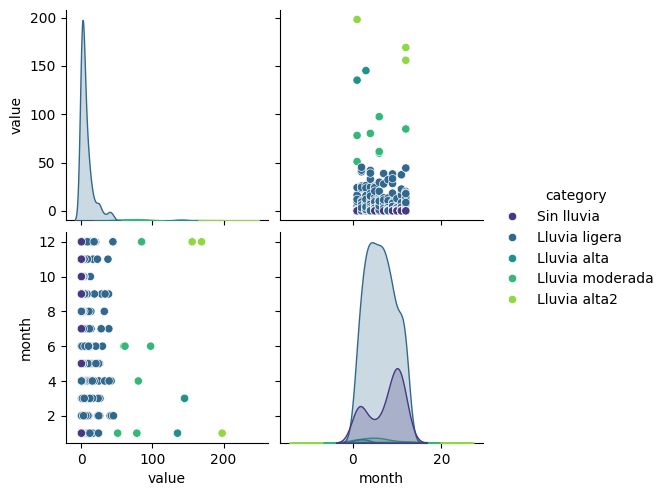

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt



# Crear el pairplot
sns.pairplot(historical_series, vars=['value', 'month'], hue='category', palette='viridis')

# Mostrar la gráfica
plt.show()

In [14]:

test_stationarity(historical_series['value'])
box_fig = fig_boxplot(historical_series, params)
box_fig.show()

Resultados de la Prueba de Dickey-Fuller Aumentada:
Estadístico de Prueba: -5.150835403841771
Valor P: 1.1068686256456426e-05
Número de Retardos Usados: 7
Número de Observaciones: 326
Valores Críticos:
  1%: -3.4505694423906546
  5%: -2.8704469462727795
  10%: -2.5715154495841017

La serie es estacionaria (se rechaza H₀).


In [15]:
serie_descompuesta = decompose_time_series(historical_series, periods_s=90)
scatter = multi_scatter( Tendencia=serie_descompuesta['trend'], Estacional=serie_descompuesta['seasonal'], Residuo=serie_descompuesta['resid'])
scatter.show()


Frecuencia inferida: D


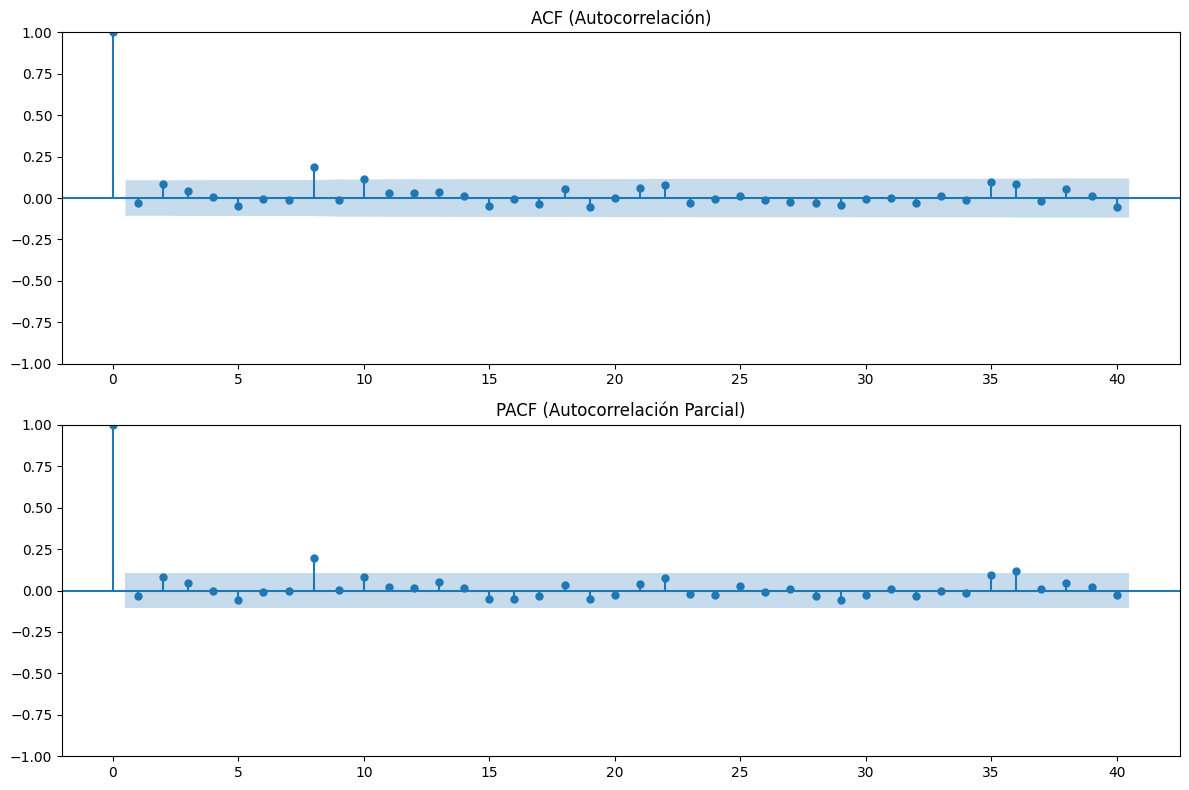

In [16]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Graficar ACF y PACF para la serie original o diferenciada
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(historical_series['value'].dropna(), lags=40, ax=ax[0])
ax[0].set_title("ACF (Autocorrelación)")

plot_pacf(historical_series['value'].dropna(), lags=40, ax=ax[1])
ax[1].set_title("PACF (Autocorrelación Parcial)")

plt.tight_layout()
plt.show()


                           value  qf     month         category
timestamp                                                      
2009-02-01 00:00:00+00:00    0.0   1  February       Sin lluvia
2009-02-02 00:00:00+00:00    0.7   1  February    Lluvia ligera
2009-02-03 00:00:00+00:00   23.3   1  February    Lluvia ligera
2009-02-04 00:00:00+00:00    0.0   1  February       Sin lluvia
2009-02-05 00:00:00+00:00    0.0   1  February       Sin lluvia
...                          ...  ..       ...              ...
2009-12-27 00:00:00+00:00   53.3   1  December  Lluvia moderada
2009-12-28 00:00:00+00:00    0.3   1  December    Lluvia ligera
2009-12-29 00:00:00+00:00    0.0   1  December       Sin lluvia
2009-12-30 00:00:00+00:00    0.0   1  December       Sin lluvia
2009-12-31 00:00:00+00:00    0.0   1  December       Sin lluvia

[334 rows x 4 columns]
                                      SARIMAX Results                                      
Dep. Variable:                               value  

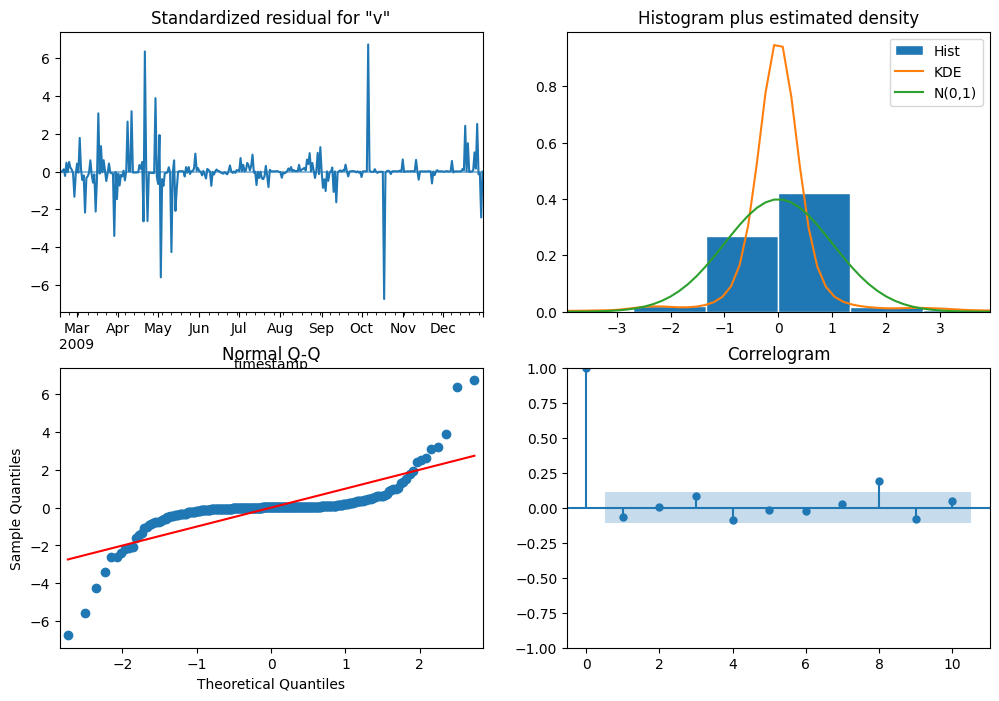

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Parámetros para el modelo SARIMA
p, d, q = 0, 1, 1  # Ajusta según ACF/PACF
P, D, Q, S = 0, 1, 0, 12  # Estacionalidad (S=12 para datos mensuales)

# Ajustar modelo SARIMA
sarima_model = SARIMAX(historical_series['value'], 
                       order=(p, d, q), 
                       seasonal_order=(P, D, Q, S),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_result = sarima_model.fit()

sarima_pronostic = sarima_result.predict()
print(historical_series)

# Resumen del modelo
print(sarima_result.summary())

# Graficar diagnóstico
sarima_result.plot_diagnostics(figsize=(12, 8))
plt.show()


## Calculo del error medio cuadrado
Con esto cuantificamos el valor del error cuadratico medio para poder estimar la fiabilidad en el resultadod e los pronosticos.

In [18]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(historical_series['value'],sarima_pronostic))
print(rmse)

20.9866264734659


# Implementacion del modelo autoarima para la serie de precipitacion

In [19]:
from pmdarima import auto_arima
from pandas.tseries.offsets import DateOffset

# Datos de entrenamiento

model = auto_arima(
    y=historical_series['value'],                # Serie temporal
    seasonal=True,          # Modelos SARIMA (True para datos estacionales)
    m=6,                   # Frecuencia estacional (por ejemplo, 12 para datos mensuales)
    stepwise=True,          # Optimización rápida (por defecto True)
    trace=True              # Imprime el progreso del ajuste
)

# Resumen del modelo
print(model.summary())

# Predicciones
forecast = model.predict(n_periods=10)  # Predice los próximos 10 valores


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=inf, Time=3.51 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=2998.095, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=2877.787, Time=0.74 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=2996.095, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[6] intercept   : AIC=2877.581, Time=0.08 sec
 ARIMA(1,1,0)(0,0,1)[6] intercept   : AIC=2877.680, Time=0.40 sec
 ARIMA(1,1,0)(1,0,1)[6] intercept   : AIC=2879.633, Time=1.03 sec
 ARIMA(2,1,0)(0,0,0)[6] intercept   : AIC=2840.080, Time=0.14 sec
 ARIMA(2,1,0)(1,0,0)[6] intercept   : AIC=2840.734, Time=0.35 sec
 ARIMA(2,1,0)(0,0,1)[6] intercept   : AIC=2840.772, Time=0.25 sec
 ARIMA(2,1,0)(1,0,1)[6] intercept   : AIC=2842.726, Time=0.30 sec
 ARIMA(3,1,0)(0,0,0)[6] intercept   : AIC=2826.185, Time=0.16 sec
 ARIMA(3,1,0)(1,0,0)[6] intercept   : AIC=2825.911, Time=0.16 sec
 ARIMA(3,1,0)(2,0,0)[6] intercept   : AIC=2

In [20]:
from graphics_utils.go import multi_line
# Generar predicciones sobre las mismas fechas
historical_series["serie"] = model.predict_in_sample()
rmse = np.sqrt(mean_squared_error(historical_series['value'],historical_series['serie']))
print(rmse)
fig_comparations = multi_line(Insitu = historical_series['value'], ARIMA = sarima_pronostic, Auto_ARIMA = historical_series['serie'])
fig_comparations.show()



15.022835087969579
